In [1]:
import os
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image, ImageChops
from scipy import ndimage

In [2]:
def load_data(datadir,categories):
    
    datalength = 0
    data = list()
    labels = list()
    for i,category in enumerate(categories):
        path = os.path.join(datadir,category)
        path_list = os.listdir(path)
        if('.DS_Store') in path_list:
            path_list.remove('.DS_Store')
        for img in path_list:
            img_ = os.path.join(path,img)
            img_ = cv2.imread(img_)
            img_ = cv2.cvtColor(img_,cv2.COLOR_BGR2RGB)
            data.append(img_)
            
    return np.asarray(data)

def visualize(images):
    i = 0
    
    rows = 4
    columns = 3
    fig=plt.figure(figsize=(12, 12))
    
    for image in images:
        
        fig.add_subplot(rows,columns,i+1)
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.title("Image "+str(i+1))
        i+=1

def rotate_image(mat, angle):

    height, width = mat.shape[:2] 
    image_center = (width/2, height/2) 

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)
    val = int(mat[1][0][0])
   
    abs_cos = abs(rotation_mat[0,0]) 
    abs_sin = abs(rotation_mat[0,1])

    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]
    
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h),borderValue=(val,val,val))
    return rotated_mat

def skew_correction(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    thresh = cv2.threshold(gray, 0, 255,
    cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]
    
    if angle < -45:
        angle = -(90 + angle)

    else:
        angle = -angle
        
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h),
        flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
#     References: https://www.pyimagesearch.com/2017/02/20/text-skew-correction-opencv-python/
    return rotated

def HoughLinesTransform(img):

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_edges = cv2.Canny(img_gray, 100, 100, apertureSize=3)
    lines = cv2.HoughLinesP(img_edges, 1, math.pi / 180.0, 100, minLineLength=3, maxLineGap=3)
    

    angles = []
    val = img[0][0][0]

    for [[x1, y1, x2, y2]] in lines:
        angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
        angles.append(angle)

    median_angle = np.median(angles)
    img_rotated = ndimage.rotate(img, median_angle,mode='constant',cval=val)

    return img_rotated


def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    
    bbox = diff.getbbox()
    
    if bbox:
        x = bbox[0] #left
        y = bbox[1] #top
        v = bbox[2] #right
        z = bbox[3] #bottom
        to_crop = tuple((x,y,v,z))
        return im.crop(to_crop)

def normalize(img):
    rgb_planes = cv2.split(img)

    result_planes = []
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        result_planes.append(diff_img)
        result_norm_planes.append(norm_img)

    result = cv2.merge(result_planes)
    result_norm = cv2.merge(result_norm_planes)
    return result_norm

def line_removal(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
    baseline = np.zeros(gray.shape,dtype="uint8")
    
    horizontal_line = cv2.getStructuringElement(cv2.MORPH_RECT,(40,1))
    remove_horizontal = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,horizontal_line,iterations=2)
    cnts = cv2.findContours(remove_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(baseline, [c], -1, (255,255,255), 3)
    
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,40))
    remove_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
    cnts = cv2.findContours(remove_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(baseline, [c], -1, (255,255,255), 3)

    dst = cv2.inpaint(gray,baseline,2,cv2.INPAINT_TELEA)
    
    return dst, baseline

def save(img,name):
    cv2.imwrite('Line Removal/'+name+'.jpg',np.asarray(img))
    

In [3]:
def main():
    # data-preprocessing

    # loading data
    data = load_data('Renamed',['0','1','2','3','4','5','6','7','8','9'])

    # Hough-line Transform
    data_transformed = list()
    for i in range(len(data)):
        data_transformed.append(HoughLinesTransform(data[i]))

    # Trimming
    data_trim = list()
    for i in range(len(data_transformed)):
        data_trim.append(trim(Image.fromarray(data_transformed[i])))

    # Normalize
    img = list()
    for i in range(len(data_trim)):
        img.append(normalize(np.asarray(data_trim[i])))

    # Line Removal
    final_img = list()
    for i in range(len(img)):
        dst, baseline= line_removal(img[i])
        final_img.append(dst)
        
    create_line_removal_images(final_img)


In [4]:
def create_line_removal_images(final_img):
    j = 0
    for i in range(len(final_img)):

        if i < 50:
            code = 'a'
        elif i >=50 and i <100:
            code = 'b'
        elif i >=100 and i <150:
            code = 'c'
        elif i >=150 and i <200:
            code = 'd'
        elif i >=200 and i <250:
            code = 'e'
        elif i >=250 and i <300:
            code = 'f'
        elif i >=300 and i <350:
            code = 'g'
        elif i >=350 and i <400:
            code = 'h'
        elif i >=400 and i <450:
            code = 'i'
        elif i >=450 and i <500:
            code = 'j'

        if j == 49:
            j = 0
        else:
            j+=1

        name = str(code)+'_'+str("{0:03}".format(j))

        save(final_img[i],name)

## Line Segmentation

In [3]:
import cv2
import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from scipy.signal import argrelmin

import os
import warnings
warnings.filterwarnings('ignore')
#%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
sns.set(rc={'figure.figsize' : (22, 10)})
sns.set_style("darkgrid", {'axes.grid' : True})

In [4]:
def crop_text_to_lines(text, blanks):
    x1 = 0
    y = 0
    lines = []
    for i, blank in enumerate(blanks):
        x2 = blank
        print("x1=", x1, ", x2=", x2, ", Diff= ", x2-x1)
        line = text[:, x1:x2]
        lines.append(line)
        x1 = blank
    return lines

def display_lines(lines_arr, orient='vertical'):
    plt.figure(figsize=(30, 30))
    if not orient in ['vertical', 'horizontal']:
        raise ValueError("Orientation is on of 'vertical', 'horizontal', defaul = 'vertical'") 
    if orient == 'vertical': 
        for i, l in enumerate(lines_arr):
            line = l
            plt.subplot(2, 10, i+1)  # A grid of 2 rows x 10 columns
            plt.axis('off')
            plt.title("Line #{0}".format(i))
            _ = plt.imshow(line, cmap='gray', interpolation = 'bicubic')
            plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    else:
            for i, l in enumerate(lines_arr):
                line = l
                plt.subplot(40, 1, i+1)  # A grid of 40 rows x 1 columns
                plt.axis('off')
                plt.title("Line #{0}".format(i))
                _ = plt.imshow(line, cmap='gray', interpolation = 'bicubic')
                plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()
    
def smooth(x, window_len=11, window='hanning'):
#     if x.ndim != 1:
#         raise ValueError("smooth only accepts 1 dimension arrays.") 
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.") 
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'") 
    s = np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w = np.ones(window_len,'d')
    else:
        w = eval('np.'+window+'(window_len)')

    y = np.convolve(w/w.sum(),s,mode='valid')
    return y

def createKernel(kernelSize, sigma, theta):
    "create anisotropic filter kernel according to given parameters"
    assert kernelSize % 2 # must be odd size
    halfSize = kernelSize // 2

    kernel = np.zeros([kernelSize, kernelSize])
    sigmaX = sigma
    sigmaY = sigma * theta

    for i in range(kernelSize):
        for j in range(kernelSize):
            x = i - halfSize
            y = j - halfSize

            expTerm = np.exp(-x**2 / (2 * sigmaX) - y**2 / (2 * sigmaY))
            xTerm = (x**2 - sigmaX**2) / (2 * math.pi * sigmaX**5 * sigmaY)
            yTerm = (y**2 - sigmaY**2) / (2 * math.pi * sigmaY**5 * sigmaX)

            kernel[i, j] = (xTerm + yTerm) * expTerm

    kernel = kernel / np.sum(kernel)
    return kernel

def applySummFunctin(img):
    res = np.sum(img, axis = 0)    #  summ elements in columns
    return res

def transpose_lines(lines):
    res = []
    for l in lines:
        line = np.transpose(l)
        res.append(line)
    return res

def showImg(img, cmap=None):
    plt.imshow(img, cmap=cmap, interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

def normalize(img):
    (m, s) = cv2.meanStdDev(img)
    m = m[0][0]
    s = s[0][0]
    img = img - m
    img = img / s if s>0 else img
    return img

In [5]:
def load_line_removal_data(datadir,code):
    
    datalength = 0
    data = list()
    labels = list()
    
    path_list = os.listdir(datadir)
    if('.DS_Store') in path_list:
        path_list.remove('.DS_Store')
        
    for img in path_list:
        img_ = os.path.join(datadir,img)
        if img[0] == code:
            #img_ = cv2.imread(img_)
            #img_ = cv2.cvtColor(img_,cv2.COLOR_BGR2RGB)
            data.append(img)
            
    return np.asarray(data)

def save(img,name,code):
    direc = code
    cv2.imwrite('../Segment/'+str(code)+'/'+name+'.jpg',np.asarray(img))

In [6]:
def main():
    kernelSize=25
    sigma=12
    theta=3
    data = list()
    data = load_line_removal_data("../Line Removal",'j')
    for i in range(len(data)):
        code = data[0][0]
        img = "../Line Removal/"+str(data[i])
        img_ = cv2.imread(img)

        img_2 = cv2.cvtColor(img_, cv2.COLOR_BGR2GRAY)
        img_3 = np.transpose(img_2)
        k = createKernel(kernelSize, sigma, theta)
        imgFiltered = cv2.filter2D(img_3, -1, k, borderType=cv2.BORDER_REPLICATE)
        img_4 = normalize(imgFiltered)
        summ3 = applySummFunctin(img_4)
        smoothed3 = smooth(summ3, 35)
        mins3 = argrelmin(smoothed3, order=2)
        arr_mins3 = np.array(mins3)
        found_lines3 = crop_text_to_lines(img_3, arr_mins3[0])
        res_lines3 = transpose_lines(found_lines3)
        j = 0
        for segment in range(len(res_lines3)):
            if res_lines3[segment].shape[0]!=0:
                img_segment = trim(Image.fromarray(res_lines3[segment]))
                if img_segment is not None:
                    j+=1
                    name = data[i][:-4] + '_' + str("{0:03}".format(j))
                    save(img_segment,name,code)

In [50]:
main()

x1= 0 , x2= 3 , Diff=  3
x1= 3 , x2= 31 , Diff=  28
x1= 31 , x2= 136 , Diff=  105
x1= 136 , x2= 180 , Diff=  44
x1= 180 , x2= 216 , Diff=  36
x1= 216 , x2= 250 , Diff=  34
x1= 250 , x2= 340 , Diff=  90
x1= 340 , x2= 396 , Diff=  56
x1= 396 , x2= 479 , Diff=  83
x1= 479 , x2= 550 , Diff=  71
x1= 550 , x2= 620 , Diff=  70
x1= 620 , x2= 692 , Diff=  72
x1= 692 , x2= 766 , Diff=  74
x1= 766 , x2= 838 , Diff=  72
x1= 838 , x2= 878 , Diff=  40
x1= 878 , x2= 915 , Diff=  37
x1= 0 , x2= 9 , Diff=  9
x1= 9 , x2= 25 , Diff=  16
x1= 25 , x2= 110 , Diff=  85
x1= 110 , x2= 145 , Diff=  35
x1= 145 , x2= 174 , Diff=  29
x1= 174 , x2= 202 , Diff=  28
x1= 202 , x2= 233 , Diff=  31
x1= 233 , x2= 323 , Diff=  90
x1= 323 , x2= 387 , Diff=  64
x1= 387 , x2= 444 , Diff=  57
x1= 444 , x2= 504 , Diff=  60
x1= 504 , x2= 565 , Diff=  61
x1= 565 , x2= 623 , Diff=  58
x1= 623 , x2= 715 , Diff=  92
x1= 715 , x2= 744 , Diff=  29
x1= 0 , x2= 6 , Diff=  6
x1= 6 , x2= 28 , Diff=  22
x1= 28 , x2= 116 , Diff=  88
x1= 11

x1= 0 , x2= 3 , Diff=  3
x1= 3 , x2= 31 , Diff=  28
x1= 31 , x2= 75 , Diff=  44
x1= 75 , x2= 136 , Diff=  61
x1= 136 , x2= 178 , Diff=  42
x1= 178 , x2= 214 , Diff=  36
x1= 214 , x2= 249 , Diff=  35
x1= 249 , x2= 296 , Diff=  47
x1= 296 , x2= 316 , Diff=  20
x1= 316 , x2= 368 , Diff=  52
x1= 368 , x2= 394 , Diff=  26
x1= 394 , x2= 472 , Diff=  78
x1= 472 , x2= 547 , Diff=  75
x1= 547 , x2= 606 , Diff=  59
x1= 606 , x2= 693 , Diff=  87
x1= 693 , x2= 765 , Diff=  72
x1= 765 , x2= 849 , Diff=  84
x1= 849 , x2= 908 , Diff=  59
x1= 0 , x2= 1 , Diff=  1
x1= 1 , x2= 33 , Diff=  32
x1= 33 , x2= 142 , Diff=  109
x1= 142 , x2= 190 , Diff=  48
x1= 190 , x2= 227 , Diff=  37
x1= 227 , x2= 263 , Diff=  36
x1= 263 , x2= 305 , Diff=  42
x1= 305 , x2= 418 , Diff=  113
x1= 418 , x2= 509 , Diff=  91
x1= 509 , x2= 588 , Diff=  79
x1= 588 , x2= 660 , Diff=  72
x1= 660 , x2= 747 , Diff=  87
x1= 747 , x2= 825 , Diff=  78
x1= 825 , x2= 941 , Diff=  116
x1= 941 , x2= 991 , Diff=  50
x1= 991 , x2= 1025 , Diff= 

x1= 0 , x2= 7 , Diff=  7
x1= 7 , x2= 27 , Diff=  20
x1= 27 , x2= 115 , Diff=  88
x1= 115 , x2= 151 , Diff=  36
x1= 151 , x2= 182 , Diff=  31
x1= 182 , x2= 211 , Diff=  29
x1= 211 , x2= 254 , Diff=  43
x1= 254 , x2= 287 , Diff=  33
x1= 287 , x2= 339 , Diff=  52
x1= 339 , x2= 405 , Diff=  66
x1= 405 , x2= 466 , Diff=  61
x1= 466 , x2= 527 , Diff=  61
x1= 527 , x2= 588 , Diff=  61
x1= 588 , x2= 650 , Diff=  62
x1= 650 , x2= 742 , Diff=  92
x1= 742 , x2= 778 , Diff=  36
x1= 0 , x2= 35 , Diff=  35
x1= 35 , x2= 76 , Diff=  41
x1= 76 , x2= 131 , Diff=  55
x1= 131 , x2= 174 , Diff=  43
x1= 174 , x2= 206 , Diff=  32
x1= 206 , x2= 237 , Diff=  31
x1= 237 , x2= 278 , Diff=  41
x1= 278 , x2= 331 , Diff=  53
x1= 331 , x2= 389 , Diff=  58
x1= 389 , x2= 453 , Diff=  64
x1= 453 , x2= 522 , Diff=  69
x1= 522 , x2= 591 , Diff=  69
x1= 591 , x2= 663 , Diff=  72
x1= 663 , x2= 731 , Diff=  68
x1= 731 , x2= 836 , Diff=  105
x1= 836 , x2= 877 , Diff=  41
x1= 0 , x2= 7 , Diff=  7
x1= 7 , x2= 27 , Diff=  20
x1

In [12]:
img = "../src/Line Removed/a_000.jpg"
img_ = cv2.imread(img)

In [13]:
img_2 = cv2.cvtColor(img_, cv2.COLOR_BGR2GRAY)

In [14]:
img = HoughLinesTransform(np.asarray(img_))

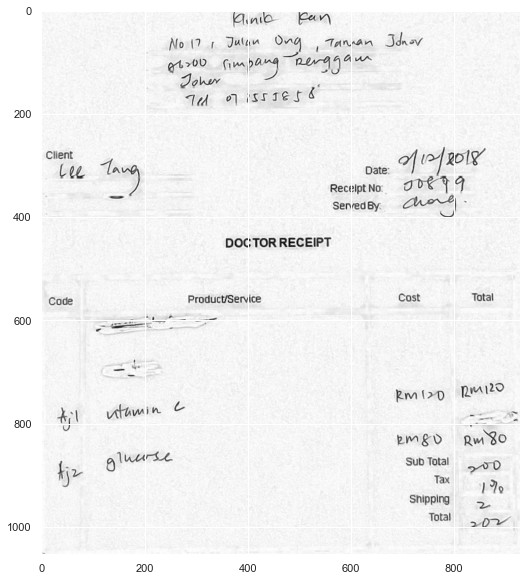

In [15]:
plt.imshow(img)

In [16]:
final = trim(Image.fromarray(img))

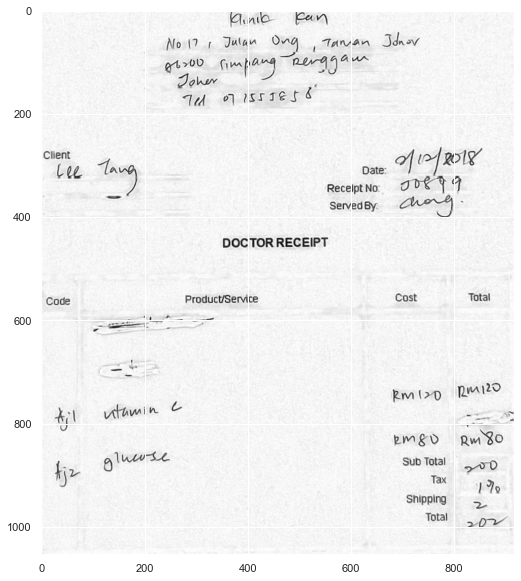

In [17]:
plt.imshow(final)

In [203]:
cv2.imwrite('b_012.jpg',np.asarray(img_2))

True

## Word Segmentation

In [82]:
import math
import cv2
import numpy as np


def wordSegmentation(img, kernelSize=25, sigma=11, theta=7, minArea=0):
    """Scale space technique for word segmentation proposed by R. Manmatha: http://ciir.cs.umass.edu/pubfiles/mm-27.pdf

    Args:
        img: grayscale uint8 image of the text-line to be segmented.
        kernelSize: size of filter kernel, must be an odd integer.
        sigma: standard deviation of Gaussian function used for filter kernel.
        theta: approximated width/height ratio of words, filter function is distorted by this factor.
        minArea: ignore word candidates smaller than specified area.

    Returns:
        List of tuples. Each tuple contains the bounding box and the image of the segmented word.
    """

    # apply filter kernel
    kernel = createKernel(kernelSize, sigma, theta)
    imgFiltered = cv2.filter2D(img, -1, kernel, borderType=cv2.BORDER_REPLICATE).astype(np.uint8)
    (_, imgThres) = cv2.threshold(imgFiltered, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    imgThres = 255 - imgThres

    # find connected components. OpenCV: return type differs between OpenCV2 and 3
    if cv2.__version__.startswith('3.'):
        (_, components, _) = cv2.findContours(imgThres, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    else:
        (components, _) = cv2.findContours(imgThres, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # append components to result
    res = []
    for c in components:
        # skip small word candidates
        if cv2.contourArea(c) < minArea:
            continue
        # append bounding box and image of word to result list
        currBox = cv2.boundingRect(c) # returns (x, y, w, h)
        (x, y, w, h) = currBox
        currImg = img[y:y+h, x:x+w]
        res.append((currBox, currImg))

    # return list of words, sorted by x-coordinate
    return sorted(res, key=lambda entry:entry[0][0])


def prepareImg(img, height):
    """convert given image to grayscale image (if needed) and resize to desired height"""
    assert img.ndim in (2, 3)
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h = img.shape[0]
    factor = height / h
    return cv2.resize(img, dsize=None, fx=factor, fy=factor)


def createKernel(kernelSize, sigma, theta):
    """create anisotropic filter kernel according to given parameters"""
    assert kernelSize % 2 # must be odd size
    halfSize = kernelSize // 2

    kernel = np.zeros([kernelSize, kernelSize])
    sigmaX = sigma
    sigmaY = sigma * theta

    for i in range(kernelSize):
        for j in range(kernelSize):
            x = i - halfSize
            y = j - halfSize

            expTerm = np.exp(-x**2 / (2 * sigmaX) - y**2 / (2 * sigmaY))
            xTerm = (x**2 - sigmaX**2) / (2 * math.pi * sigmaX**5 * sigmaY)
            yTerm = (y**2 - sigmaY**2) / (2 * math.pi * sigmaY**5 * sigmaX)

            kernel[i, j] = (xTerm + yTerm) * expTerm

    kernel = kernel / np.sum(kernel)
    return kernel

In [10]:
def main():
    """reads images from data/ and outputs the word-segmentation to out/"""

    # read input images from 'in' directory
    imgFiles = os.listdir('Line Removal/a_000.jpg')
    for (i,f) in enumerate(imgFiles):
        print('Segmenting words of sample %s'%f)

        # read image, prepare it by resizing it to fixed height and converting it to grayscale
        img = prepareImg(cv2.imread('../data/%s'%f), 50)

        # execute segmentation with given parameters
        # -kernelSize: size of filter kernel (odd integer)
        # -sigma: standard deviation of Gaussian function used for filter kernel
        # -theta: approximated width/height ratio of words, filter function is distorted by this factor
        # - minArea: ignore word candidates smaller than specified area
        res = wordSegmentation(img, kernelSize=25, sigma=11, theta=7, minArea=100)

        # write output to 'out/inputFileName' directory
        if not os.path.exists('../out/%s'%f):
            os.mkdir('../out/%s'%f)

        # iterate over all segmented words
        print('Segmented into %d words'%len(res))
        for (j, w) in enumerate(res):
            (wordBox, wordImg) = w
            (x, y, w, h) = wordBox
            cv2.imwrite('../out/%s/%d.png'%(f, j), wordImg) # save word
            cv2.rectangle(img,(x,y),(x+w,y+h),0,1) # draw bounding box in summary image

        # output summary image with bounding boxes around words
        # cv2.imwrite('../out/%s/summary.png'%f, img)


In [161]:
img = prepareImg(cv2.imread('test4.jpg'), 50)

In [162]:
img = cv2.copyMakeBorder(img.copy(),10,10,10,10,cv2.BORDER_CONSTANT,value=(255,255,255))

res = wordSegmentation(img, kernelSize=25, sigma=11, theta=7, minArea=100)

In [163]:
for (j, w) in enumerate(res):
    (wordBox, wordImg) = w
    (x, y, w, h) = wordBox
    cv2.rectangle(img,(x,y),(x+w,y+h),0,1) # draw bounding box in summary image

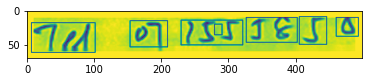

In [164]:
plt.imshow(img)

## A* Path Finding (Not work)


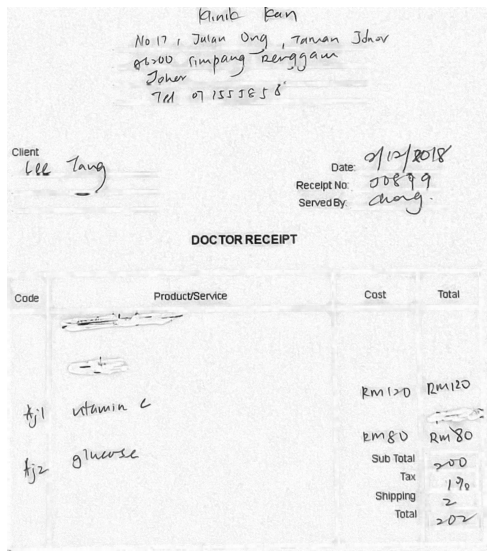

In [20]:
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

img = rgb2gray(imread("../src/Line Removed/a_000.jpg"))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(img, cmap="gray")
plt.show()

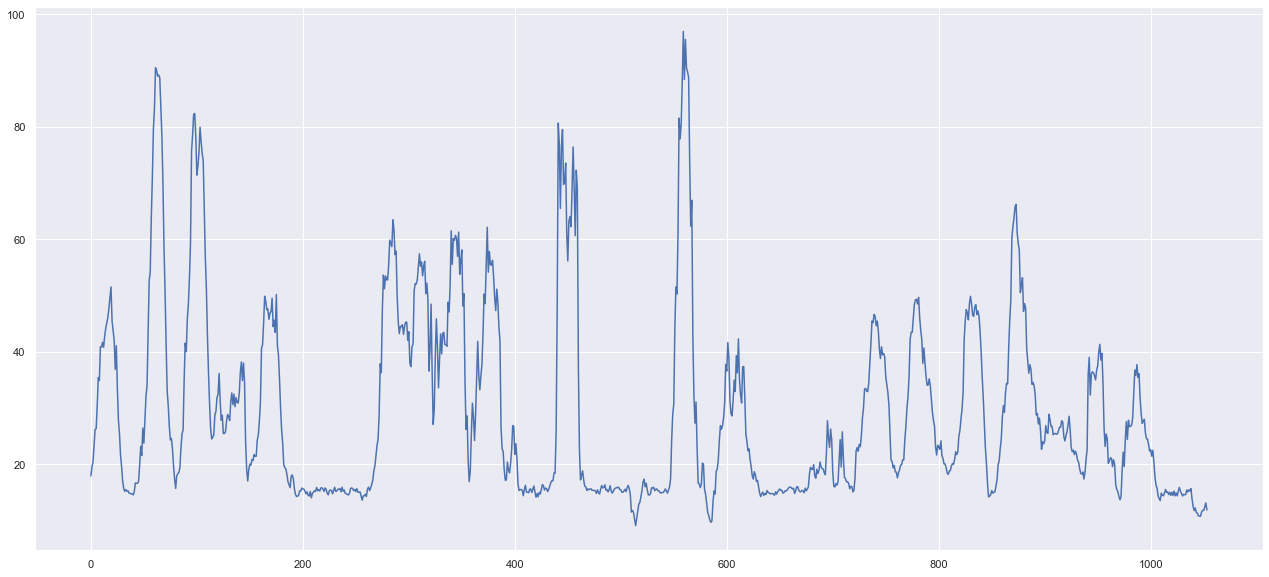

In [21]:
from skimage.filters import sobel
import numpy as np

def horizontal_projections(sobel_image):
    return np.sum(sobel_image, axis=1)  

sobel_image = sobel(img)
hpp = horizontal_projections(sobel_image)
plt.plot(hpp)
plt.show()

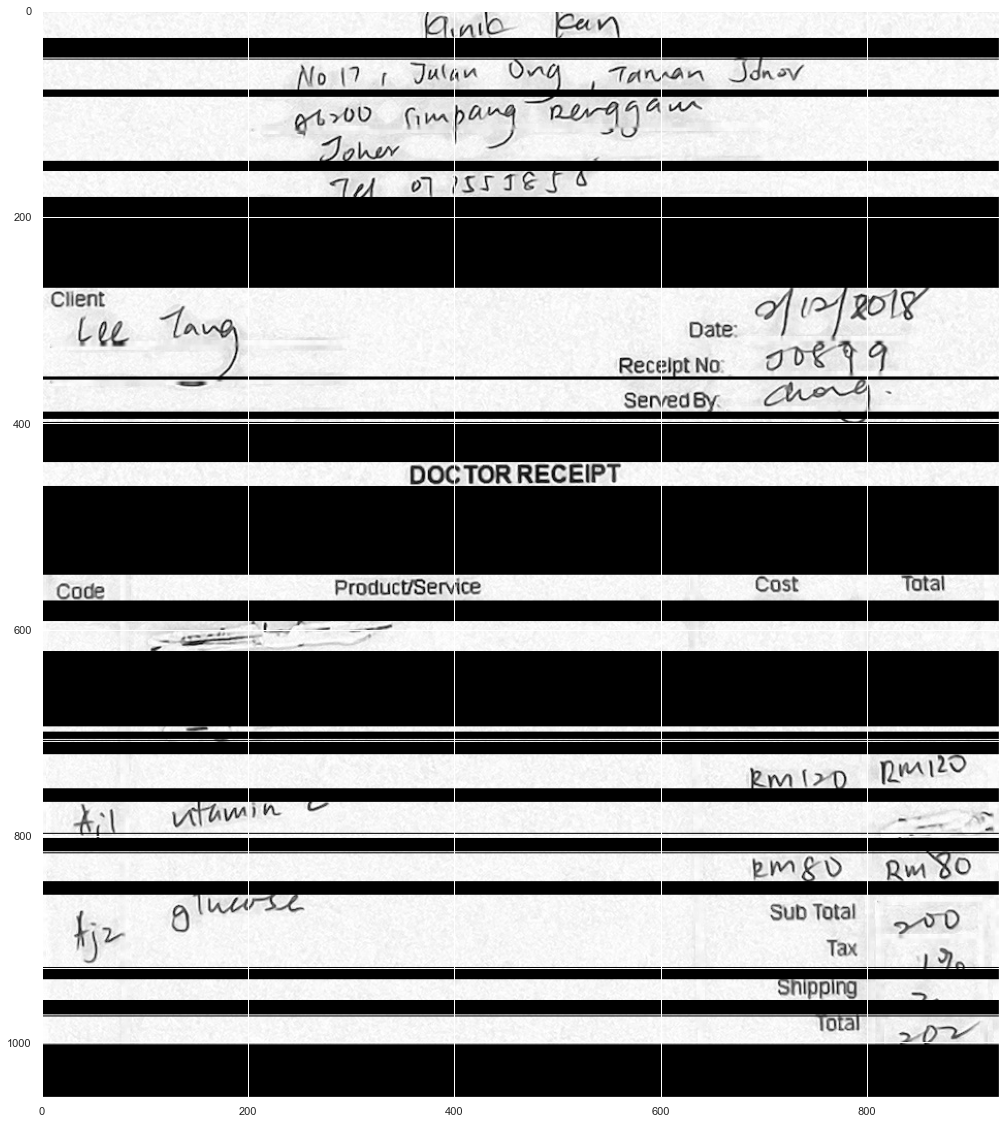

In [22]:
def find_peak_regions(hpp, divider=4):
    threshold = (np.max(hpp)-np.min(hpp))/divider
    peaks = []
    peaks_index = []
    for i, hppv in enumerate(hpp):
        if hppv < threshold:
            peaks.append([i, hppv])
    return peaks

peaks = find_peak_regions(hpp)

peaks_index = np.array(peaks)[:,0].astype(int)

segmented_img = np.copy(img)
r,c = segmented_img.shape
for ri in range(r):
    if ri in peaks_index:
        segmented_img[ri, :] = 0
        
plt.figure(figsize=(20,20))
plt.imshow(segmented_img, cmap="gray")
plt.show()

In [23]:
def get_hpp_walking_regions(peaks_index):
    hpp_clusters = []
    cluster = []
    for index, value in enumerate(peaks_index):
        cluster.append(value)

        if index < len(peaks_index)-1 and peaks_index[index+1] - value > 1:
            hpp_clusters.append(cluster)
            cluster = []

        #get the last cluster
        if index == len(peaks_index)-1:
            hpp_clusters.append(cluster)
            cluster = []
            
    return hpp_clusters

hpp_clusters = get_hpp_walking_regions(peaks_index)

In [24]:
from heapq import *

def heuristic(a, b):
    return (b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2

def astar(array, start, goal):

    neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    close_set = set()
    came_from = {}
    gscore = {start:0}
    fscore = {start:heuristic(start, goal)}
    oheap = []

    heappush(oheap, (fscore[start], start))
    
    while oheap:

        current = heappop(oheap)[1]

        if current == goal:
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j            
            tentative_g_score = gscore[current] + heuristic(current, neighbor)
            if 0 <= neighbor[0] < array.shape[0]:
                if 0 <= neighbor[1] < array.shape[1]:                
                    if array[neighbor[0]][neighbor[1]] == 1:
                        continue
                else:
                    # array bound y walls
                    continue
            else:
                # array bound x walls
                continue
                
            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue
                
            if  tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heappush(oheap, (fscore[neighbor], neighbor))
                
    return []

In [25]:
from skimage.filters import threshold_otsu
from skimage.util import invert

def get_binary(img):
    mean = np.mean(img)
    if mean == 0.0 or mean == 1.0:
        return img

    thresh = threshold_otsu(img)
    binary = img <= thresh
    binary = binary*1
    return binary

def path_exists(window_image):
    #very basic check first then proceed to A* check
    if 0 in horizontal_projections(window_image):
        return True
    
    padded_window = np.zeros((window_image.shape[0],1))
    world_map = np.hstack((padded_window, np.hstack((window_image,padded_window)) ) )
    path = np.array(astar(world_map, (int(world_map.shape[0]/2), 0), (int(world_map.shape[0]/2), world_map.shape[1])))
    if len(path) > 0:
        return True
    
    return False

def get_road_block_regions(nmap):
    road_blocks = []
    needtobreak = False
    
    for col in range(nmap.shape[1]):
        start = col
        end = col+20
        if end > nmap.shape[1]-1:
            end = nmap.shape[1]-1
            needtobreak = True

        if path_exists(nmap[:, start:end]) == False:
            road_blocks.append(col)

        if needtobreak == True:
            break
            
    return road_blocks

def group_the_road_blocks(road_blocks):
    #group the road blocks
    road_blocks_cluster_groups = []
    road_blocks_cluster = []
    size = len(road_blocks)
    for index, value in enumerate(road_blocks):
        road_blocks_cluster.append(value)
        if index < size-1 and (road_blocks[index+1] - road_blocks[index]) > 1:
            road_blocks_cluster_groups.append([road_blocks_cluster[0], road_blocks_cluster[len(road_blocks_cluster)-1]])
            road_blocks_cluster = []

        if index == size-1 and len(road_blocks_cluster) > 0:
            road_blocks_cluster_groups.append([road_blocks_cluster[0], road_blocks_cluster[len(road_blocks_cluster)-1]])
            road_blocks_cluster = []

    return road_blocks_cluster_groups

binary_image = get_binary(img)

for cluster_of_interest in hpp_clusters:
    nmap = binary_image[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:]
    road_blocks = get_road_block_regions(nmap)
    road_blocks_cluster_groups = group_the_road_blocks(road_blocks)
    #create the doorways
    for index, road_blocks in enumerate(road_blocks_cluster_groups):
        window_image = nmap[:, road_blocks[0]: road_blocks[1]+10]
        binary_image[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:][:, road_blocks[0]: road_blocks[1]+10][int(window_image.shape[0]/2),:] *= 0

IndexError: index 0 is out of bounds for axis 0 with size 0

In [26]:
line_segments = []
for i, cluster_of_interest in enumerate(hpp_clusters):
    nmap = binary_image[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:]
    path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2),nmap.shape[1]-1)))
    offset_from_top = cluster_of_interest[0]
    path[:,0] += offset_from_top
    line_segments.append(path)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

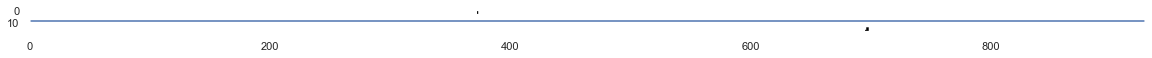

In [27]:
cluster_of_interest = hpp_clusters[1]
offset_from_top = cluster_of_interest[0]
nmap = binary_image[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:]
plt.figure(figsize=(20,20))
plt.imshow(invert(nmap), cmap="gray")

path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2),nmap.shape[1]-1)))
plt.plot(path[:,1], path[:,0])

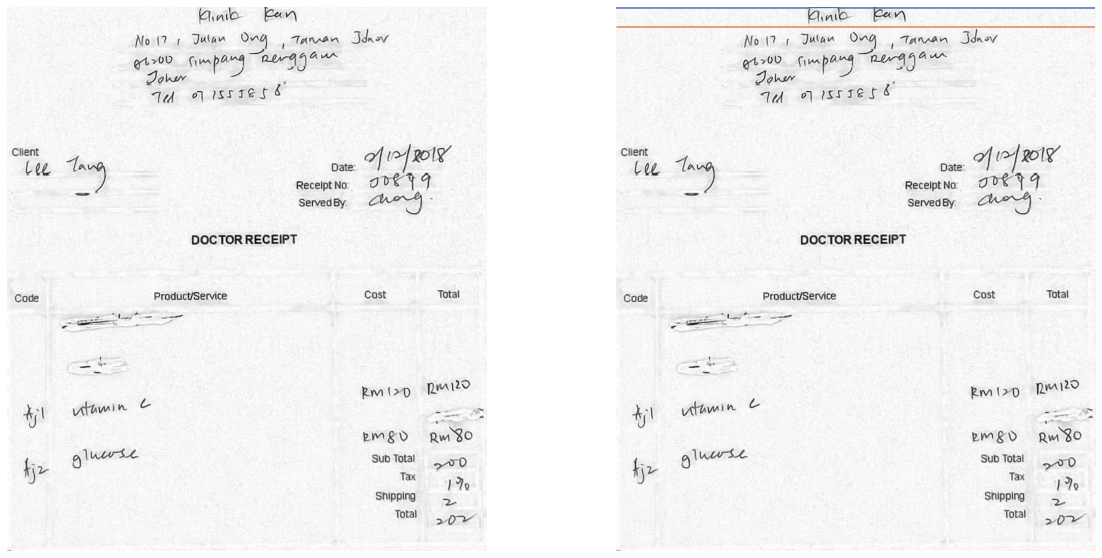

In [28]:
offset_from_top = cluster_of_interest[0]
fig, ax = plt.subplots(figsize=(20,10), ncols=2)
for path in line_segments:
    ax[1].plot((path[:,1]), path[:,0])
ax[1].axis("off")
ax[0].axis("off")
ax[1].imshow(img, cmap="gray")
ax[0].imshow(img, cmap="gray")

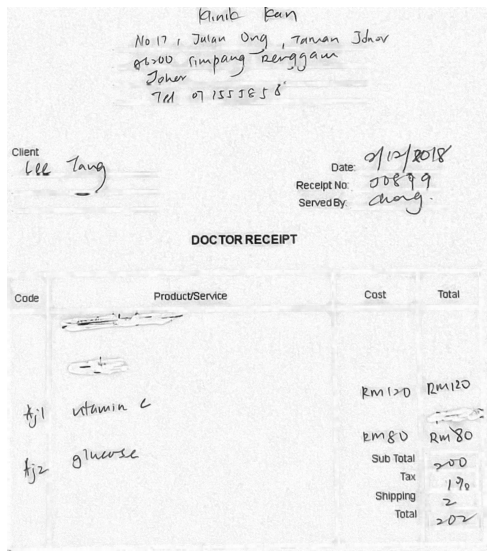

In [29]:
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

img = rgb2gray(imread("../src/Line Removed/a_000.jpg"))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(img, cmap="gray")
plt.show()

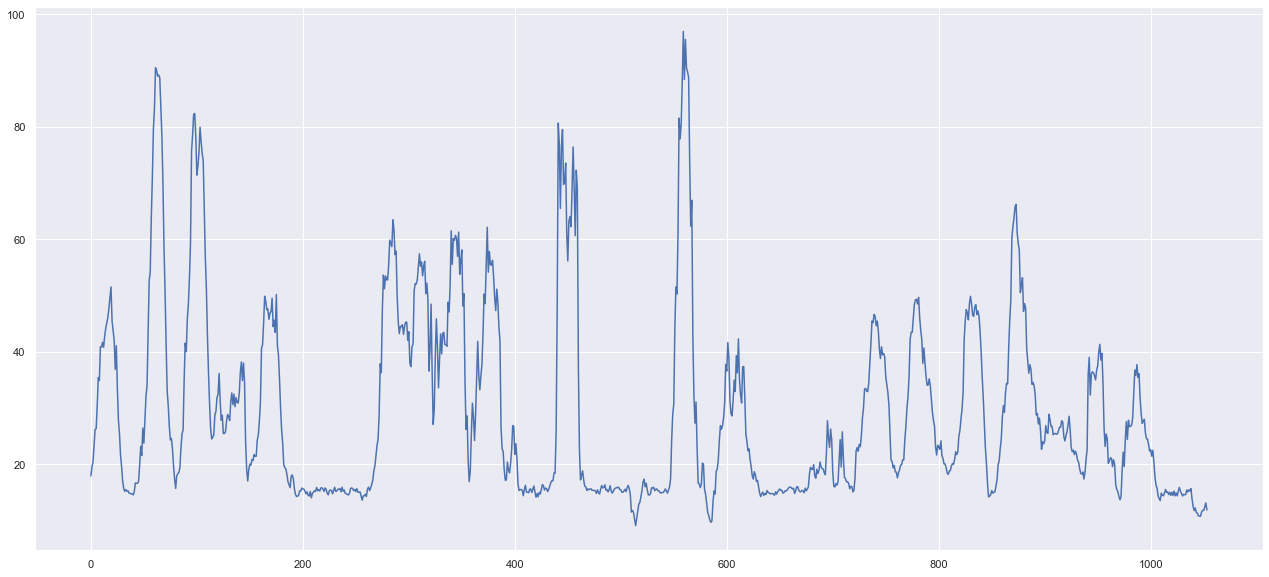

In [30]:
from skimage.filters import sobel
import numpy as np

def horizontal_projections(sobel_image):
    return np.sum(sobel_image, axis=1)  

sobel_image = sobel(img)
hpp = horizontal_projections(sobel_image)
plt.plot(hpp)
plt.show()

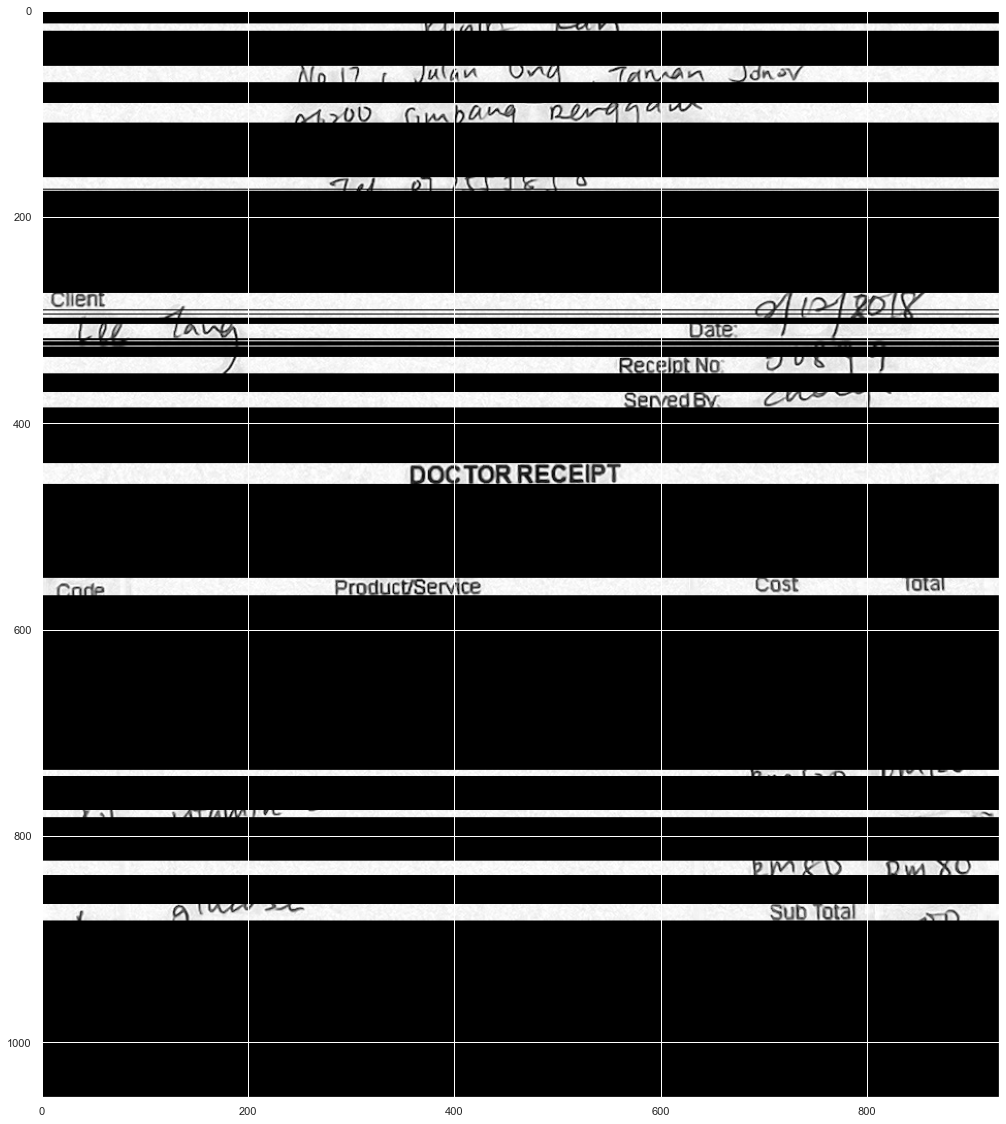

In [31]:
def find_peak_regions(hpp, divider=2):
    threshold = (np.max(hpp)-np.min(hpp))/divider
    peaks = []
    peaks_index = []
    for i, hppv in enumerate(hpp):
        if hppv < threshold:
            peaks.append([i, hppv])
    return peaks

peaks = find_peak_regions(hpp)

peaks_index = np.array(peaks)[:,0].astype(int)

segmented_img = np.copy(img)
r,c = segmented_img.shape
for ri in range(r):
    if ri in peaks_index:
        segmented_img[ri, :] = 0
        
plt.figure(figsize=(20,20))
plt.imshow(segmented_img, cmap="gray")
plt.show()

In [32]:
def get_hpp_walking_regions(peaks_index):
    hpp_clusters = []
    cluster = []
    for index, value in enumerate(peaks_index):
        cluster.append(value)

        if index < len(peaks_index)-1 and peaks_index[index+1] - value > 1:
            hpp_clusters.append(cluster)
            cluster = []

        #get the last cluster
        if index == len(peaks_index)-1:
            hpp_clusters.append(cluster)
            cluster = []
            
    return hpp_clusters

hpp_clusters = get_hpp_walking_regions(peaks_index)

In [33]:
from heapq import *

def heuristic(a, b):
    return (b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2

def astar(array, start, goal):

    neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    close_set = set()
    came_from = {}
    gscore = {start:0}
    fscore = {start:heuristic(start, goal)}
    oheap = []

    heappush(oheap, (fscore[start], start))
    
    while oheap:

        current = heappop(oheap)[1]

        if current == goal:
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j            
            tentative_g_score = gscore[current] + heuristic(current, neighbor)
            if 0 <= neighbor[0] < array.shape[0]:
                if 0 <= neighbor[1] < array.shape[1]:                
                    if array[neighbor[0]][neighbor[1]] == 1:
                        continue
                else:
                    # array bound y walls
                    continue
            else:
                # array bound x walls
                continue
                
            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue
                
            if  tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heappush(oheap, (fscore[neighbor], neighbor))
                
    return []

In [35]:
from skimage.filters import threshold_otsu
from skimage.util import invert

def get_binary(img):
    mean = np.mean(img)
    if mean == 0.0 or mean == 1.0:
        return img

    thresh = threshold_otsu(img)
    binary = img <= thresh
    binary = binary*1
    return binary

def path_exists(window_image):
    #very basic check first then proceed to A* check
    if 0 in horizontal_projections(window_image):
        return True
    
    padded_window = np.zeros((window_image.shape[0],1))
    world_map = np.hstack((padded_window, np.hstack((window_image,padded_window)) ) )
    path = np.array(astar(world_map, (int(world_map.shape[0]/2), 0), (int(world_map.shape[0]/2), world_map.shape[1])))
    if len(path) > 0:
        return True
    
    return False

def get_road_block_regions(nmap):
    road_blocks = []
    needtobreak = False
    
    for col in range(nmap.shape[1]):
        start = col
        end = col+20
        if end > nmap.shape[1]-1:
            end = nmap.shape[1]-1
            needtobreak = True

        if path_exists(nmap[:, start:end]) == False:
            road_blocks.append(col)

        if needtobreak == True:
            break
            
    return road_blocks

def group_the_road_blocks(road_blocks):
    #group the road blocks
    road_blocks_cluster_groups = []
    road_blocks_cluster = []
    size = len(road_blocks)
    for index, value in enumerate(road_blocks):
        road_blocks_cluster.append(value)
        if index < size-1 and (road_blocks[index+1] - road_blocks[index]) > 1:
            road_blocks_cluster_groups.append([road_blocks_cluster[0], road_blocks_cluster[len(road_blocks_cluster)-1]])
            road_blocks_cluster = []

        if index == size-1 and len(road_blocks_cluster) > 0:
            road_blocks_cluster_groups.append([road_blocks_cluster[0], road_blocks_cluster[len(road_blocks_cluster)-1]])
            road_blocks_cluster = []

    return road_blocks_cluster_groups

binary_image = get_binary(img)

for cluster_of_interest in hpp_clusters:
    nmap = binary_image[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:]
    road_blocks = get_road_block_regions(nmap)
    road_blocks_cluster_groups = group_the_road_blocks(road_blocks)
    #create the doorways
    for index, road_blocks in enumerate(road_blocks_cluster_groups):
        window_image = nmap[:, road_blocks[0]: road_blocks[1]+10]
        binary_image[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:][:, road_blocks[0]: road_blocks[1]+10][int(window_image.shape[0]/2),:] *= 0
        

IndexError: index 0 is out of bounds for axis 0 with size 0

In [44]:
line_segments = []
for i, cluster_of_interest in enumerate(hpp_clusters):
    nmap = binary_image[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:]
    path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2),nmap.shape[1]-1)))
    offset_from_top = cluster_of_interest[0]
    path[:,0] += offset_from_top
    line_segments.append(path)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed